In [169]:
import numpy as np # linear algebra
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms
from PIL import Image
import os
from torchvision.io import read_image
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [170]:
dataset = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv")
dataset.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [171]:
dataset.shape

(10015, 2353)

In [172]:
dataset['label'].unique()
    

array([2, 4, 3, 6, 5, 1, 0])

2


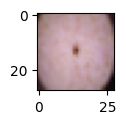

In [173]:
label = dataset.iloc[12,2352]
image = dataset.iloc[12,0:2352]

torch_tensor = torch.tensor(image.values)
plt.figure(figsize=(1,1))
plt.imshow(torch_tensor.reshape((28,28,3)));
print(label)

In [174]:
for i in range(6):
    print( (dataset['label'] == i).sum())


327
514
1099
115
6705
142


In [175]:
dataset = dataset.sample(frac = 1)

In [179]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.img_labels = csv_file['label']
        self.img_dir = csv_file.drop(['label'], axis = 1)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx]
        image = self.img_dir.iloc[idx,:]
        torch_tensor = torch.tensor(image.values)
        image = torch_tensor.reshape((3,28,28));
        TensorToPIL = T.ToPILImage(mode = "RGB")
        image = TensorToPIL(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, torch.tensor(label)

In [180]:
preprocess = transforms.Compose([
    transforms.Resize([28,28]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [181]:
Train = CustomImageDataset(dataset[0:int(0.8*len(dataset))], transform=preprocess, target_transform=None)
Test = CustomImageDataset(dataset[int(0.8*len(dataset)):int(len(dataset))], transform=preprocess, target_transform=None)
print(Train.__len__(), Test.__len__())

8012 2003


In [182]:
train_loader = DataLoader(Train, batch_size = 100, shuffle = True) 
test_loader = DataLoader(Test, batch_size = 100, shuffle = True)

In [183]:
len(train_loader), len(test_loader)

(81, 21)

In [184]:
model = torchvision.models.resnet50(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
    
    
n = model.fc.in_features

model.fc = nn.Linear(n,7)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [185]:
if (torch.cuda.is_available()):
    print("Yes")
    device = "cuda"

Yes


In [186]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [187]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        output = model(data)  
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
       
    # return average loss for the epoch
    
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


In [188]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

   
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [190]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_criteria = torch.nn.CrossEntropyLoss( )
loss_criteria.to(device)

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
       
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cuda
Epoch: 1
Training set: Average loss: 2.018177
Validation set: Average loss: 1.237718, Accuracy: 1068/2003 (53.320%)

Epoch: 2
Training set: Average loss: 1.114610
Validation set: Average loss: 1.077853, Accuracy: 1331/2003 (66.450%)

Epoch: 3
Training set: Average loss: 1.052332
Validation set: Average loss: 1.441659, Accuracy: 1122/2003 (56.016%)

Epoch: 4
Training set: Average loss: 1.103509
Validation set: Average loss: 1.364495, Accuracy: 1309/2003 (65.352%)

Epoch: 5
Training set: Average loss: 1.083860
Validation set: Average loss: 1.355615, Accuracy: 1223/2003 (61.058%)

Epoch: 6
Training set: Average loss: 1.090919
Validation set: Average loss: 1.244527, Accuracy: 1184/2003 (59.111%)

Epoch: 7
Training set: Average loss: 1.008681
Validation set: Average loss: 1.410671, Accuracy: 961/2003 (47.978%)

Epoch: 8
Training set: Average loss: 1.049054
Validation set: Average loss: 1.212048, Accuracy: 1195/2003 (59.661%)

Epoch: 9
Training set: Average loss: 1.165305
Va